<a href="https://colab.research.google.com/github/ADebor/adebor.github.io/blob/master/notebooks/math0487_tp5_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATH0487 - TP5 - Régression
## Notebook d'accompagnement
### ULiège, Nov. 2023

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import load_iris
%matplotlib inline

## Exercice 1.4

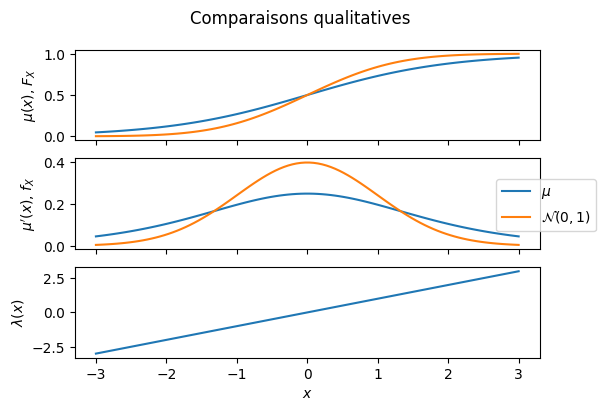

In [70]:
# paramètre de la régression logistique
theta = 1

# variable prédictive
x = np.linspace(-3, 3, 100)

# modèle logistique
def logistic(x):
  return np.exp(theta*x)/(1 + np.exp(theta*x))

# dérivée du modèle
def logistic_prime(x):
  return theta * logistic(x) * (1-logistic(x))

# log-odds
def log_odds(x):
  return np.log(logistic(x)) - np.log((1 - logistic(x)))

# plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(6, 4))
ax1.plot(x, logistic(x), label='$\mu$')
ax1.set_ylabel('$\mu(x)$, $F_X$')

ax2.plot(x, logistic_prime(x))
ax2.set_ylabel('$\mu\'(x)$, $f_X$')

ax3.plot(x, log_odds(x))
ax3.set_ylabel('$\lambda(x)$')

ax1.plot(x, stats.norm.cdf(x), label='$\mathcal{N}(0, 1)$')
ax2.plot(x, stats.norm.pdf(x))

plt.xlabel("$x$")
plt.suptitle("Comparaisons qualitatives")
fig.legend(loc='center right')

## Exercice 1.5

### 1. Scikit-Learn

In [71]:
# chargeons les données
data = load_iris()

# ne considérons que deux classes d'observation
idx = np.where(data.target != 2)
X = data.data[:, :2][idx]
y = data.target[idx]

Text(0, 0.5, 'Largeur des sépales')

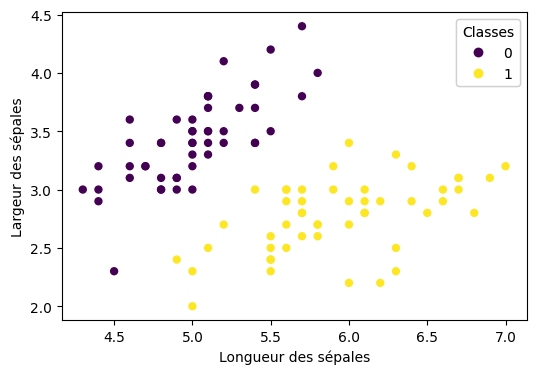

In [72]:
# visualisons les données
fig, ax = plt.subplots(figsize=(6, 4))

scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=25)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)

plt.xlabel("Longueur des sépales")
plt.ylabel("Largeur des sépales")

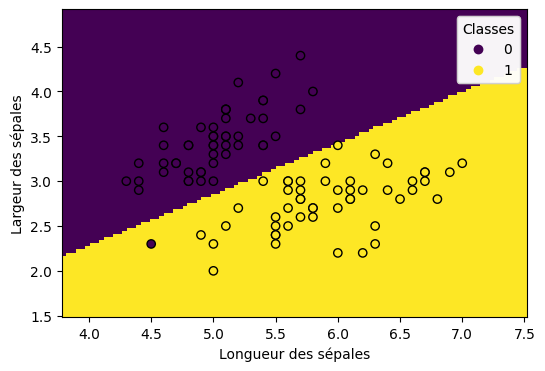

In [73]:
# créons une instance de LogisticRegression et estimons les paramètres
logreg = LogisticRegression(fit_intercept=False, C=1e5) # on force l'intercept à zéro ici
logreg.fit(X, y)  # fit du modèle sur les données

# traçons la limite décisionnelle du modèle "fitté"
_, ax = plt.subplots(figsize=(6, 4))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Longueur des sépales",
    ylabel="Largeur des sépales",
    eps=0.5,
)

# ajoutons les données à la figure
ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)

In [74]:
# extraction des coefficients
logreg.coef_

array([[  7.07168492, -12.39084019]])

### 2. Maximisation de la vraisemblance

In [75]:
# supposition initiale
theta0 = [0, 0]

# fonction "log-odds"
def log_odds(theta, x):
  return theta[0] * x[:, 0] + theta[1] * x[:, 1]

# opposé de la fonction de vraisemblance
def minus_likelihood(theta, x):
  return np.sum(np.log(1 + np.exp(log_odds(theta, x)))) - np.sum(y * log_odds(theta, x))

In [76]:
# minimisation de l'opposé de la vraisemblance
ret = minimize(fun=minus_likelihood, x0=theta0, args=X)

In [77]:
# extraction des paramètres
ret.x

array([  7.0731597 , -12.39344543])

### 3. Ascension de gradient

In [78]:
# modèle logistique à deux paramètres
def logistic2D(theta, x):
  return np.exp(log_odds(theta, x))/(1 + np.exp(log_odds(theta, x)))

# fonction score
def score(theta, idx, x):
  return np.sum(x[:, idx] * (y - logistic2D(theta, x)))

Text(0, 0.5, 'score')

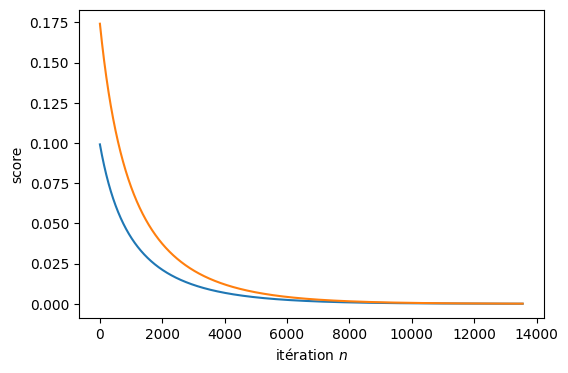

In [79]:
# supposition initiale
theta = [0, 0]

# taux d'apprentissage (learning rate)
lr = .01

scores0 = []
scores1 = []

# ascension de gradient (tant que la fonction score n'est pas <= 0.001)
while(abs(score(theta, 0, X)) > 1e-4 or abs(score(theta, 1, X)) > 1e-4):
  score0 = score(theta, 0, X)
  score1 = score(theta, 1, X)

  theta[0] += lr * score0
  theta[1] += lr * score1

  scores0.append(abs(score0))
  scores1.append(abs(score1))

# visualisation de la convergence
_, ax = plt.subplots(figsize=(6, 4))
ax.plot(scores0[80:])
ax.plot(scores1[80:])
ax.set_xlabel('itération $n$')
ax.set_ylabel('score')

In [52]:
# extraction des paramètres
theta

[7.071986538405368, -12.39137335534374]

## Exercice 1.6

Text(0, 0.5, '$y$')

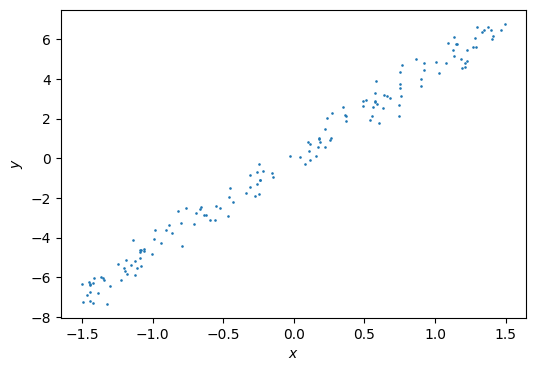

In [91]:
# nombre de points de données
n = 150

# seed
np.random.seed(1)

# génération des variables prédictives
x = np.random.uniform(low=-1.5, high=1.5, size=(n,1), )

# loi de génération artificielle
def f(x):
  return 4.5*x + np.random.normal(0, .5, np.shape(x))

# génération des observations artificielles
y = f(x)

# visualisation des données
_, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")

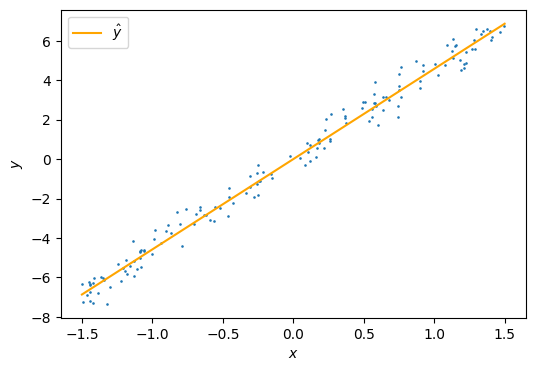

In [93]:
# estimateur MLE
theta = np.sum(np.multiply(x, y))/np.sum(x**2)

# visualisation du modèle
_, ax = plt.subplots(figsize=(6, 4))
x_model = np.linspace(-1.5, 1.5, n)
plt.plot(x_model, theta*x_model, color='orange', label="$\hat{y}$")
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [94]:
# extraction du paramètre
theta

4.580437926286525

In [95]:
# fit avec scikit-learn
reg = LinearRegression(fit_intercept=False).fit(x, y)

In [96]:
# extraction du paramètre
reg.coef_

array([[4.58043793]])

Text(0, 0.5, '$y$')

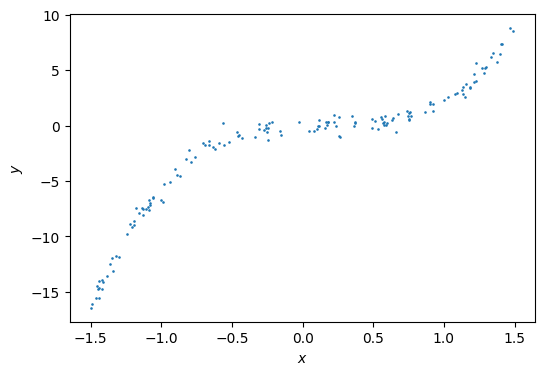

In [138]:
# loi prédictive de degré 3
def f(x):
  return 3.5*x**3 - 1.72*x**2 + 0.5*x + np.random.normal(0, .5, np.shape(x))

# génération des observations artificielles
y = f(x)

# visualisation des données
_, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")

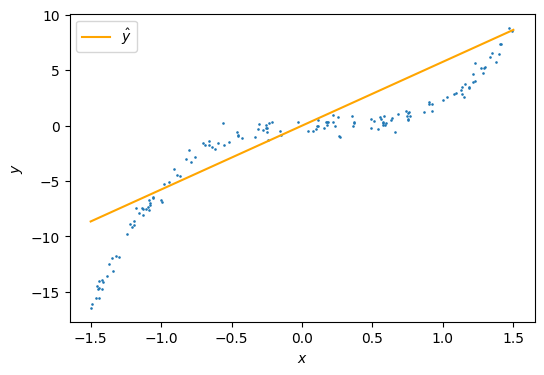

In [139]:
# estimateur MLE
theta = np.sum(np.multiply(x, y))/np.sum(x**2)

# visualisation du modèle
_, ax = plt.subplots(figsize=(6, 4))
x_model = np.linspace(-1.5, 1.5, n)
plt.plot(x_model, theta*x_model, color='orange', label="$\hat{y}$")
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

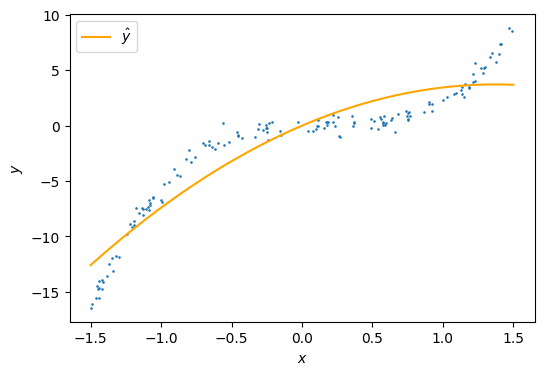

In [151]:
# ajout d'une "feature" (x²)
x_2d = np.hstack((x, x**2))

# estimation des paramètres
reg = LinearRegression(fit_intercept=False).fit(x_2d, y)

# visualisation du modèle
_, ax = plt.subplots(figsize=(6, 4))

x_model = np.linspace(-1.5, 1.5, n)
x_model_2d = np.vstack((x_model, x_model**2)).transpose()

plt.plot(x_model, reg.predict(x_model_2d), color='orange', label="$\hat{y}$")
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [152]:
# extraction des paramètres
reg.coef_

array([[ 5.42718947, -1.9771359 ]])

In [153]:
# coefficient de détermination
reg.score(x_2d, y)

0.8864887520496303

Text(0, 0.5, '$\\hat{u}$')

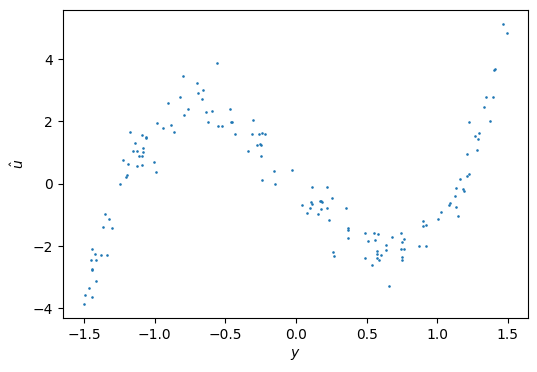

In [154]:
# calcul des résidus de régression
u = y - reg.predict(x_2d)

# visualisation
_, ax = plt.subplots(figsize=(6, 4))

plt.scatter(x, u, s=.75)
plt.xlabel("$y$")
plt.ylabel("$\hat{u}$")

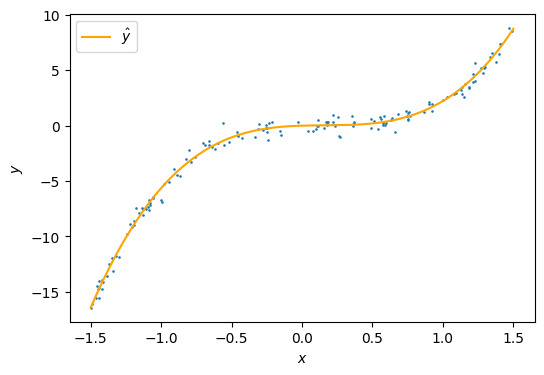

In [159]:
# ajout d'une "feature" (x^3)
x_3d = np.hstack((x, x**2, x**3))

# estimation des paramètres
reg = LinearRegression(fit_intercept=False).fit(x_3d, y)

# visualisation du modèle
_, ax = plt.subplots(figsize=(6, 4))

x_model = np.linspace(-1.5, 1.5, n)
x_model_3d = np.vstack((x_model, x_model**2, x_model**3)).transpose()

plt.plot(x_model, reg.predict(x_model_3d), color='orange', label="$\hat{y}$")
plt.scatter(x, y, s=.75)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [160]:
# extraction des paramètres
reg.coef_

array([[ 0.36560418, -1.70851351,  3.56871328]])

In [161]:
# coefficient de détermination
reg.score(x_3d, y)

0.9927682518746304

Text(0, 0.5, '$\\hat{u}$')

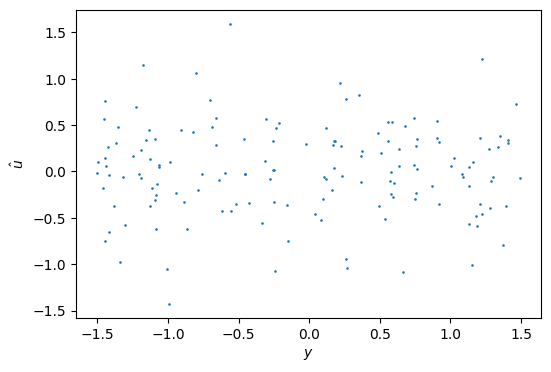

In [162]:
# calcul des résidus de régression
u = y - reg.predict(x_3d)

# visualisation
_, ax = plt.subplots(figsize=(6, 4))

plt.scatter(x, u, s=.75)
plt.xlabel("$y$")
plt.ylabel("$\hat{u}$")